In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import random
import os

In [2]:
# read in data
txn = pd.read_csv("/Users/judepereira/Downloads/ieee-fraud-detection/train_transaction.csv")
idm = pd.read_csv("/Users/judepereira/Downloads/ieee-fraud-detection/train_identity.csv")

# derive “day” from TransactionDT
txn["day"] = (txn["TransactionDT"] // (3600 * 24)).astype(int)

# derive card activation date from TransactionDT
txn['D1new'] = (txn['TransactionDT'] // (60*60*24)) - txn['D1'] + 2000

# drop TransactionDT as it is no longer needed
txn.drop("TransactionDT", axis=1, inplace=True)

# merge identity info into transaction table
df = txn.merge(idm, on="TransactionID", how="left")
df.drop("TransactionID", axis=1, inplace=True)

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [4]:
SEED = 42
seed_everything(SEED)

In [5]:
# compute missing % for all columns
nulls = df.isna().mean() * 100

# find columns with more than 80% missing values
cols_80 = nulls[nulls >= 80].index.tolist()

# and drop them!
df.drop(columns=cols_80, inplace=True)

In [6]:
id_cols = [c for c in df.columns if c.startswith("id_")]

# but id_01 to id_11 are numerical so need to exclude them
id_cat_cols = [c for c in id_cols if not c.startswith("id_0")]
id_cat_cols.remove("id_11")  # id_11 is a numerical column

# extract high cardinality categorical ID columns
id_high_card_cols = [c for c in id_cat_cols if df[c].nunique() > 10]

# one-hot encode categorical features with low cardinality
for c in id_cat_cols:
    n_uniq = df[c].nunique()
    print(f"Column: {c}, Unique values: {n_uniq}")
    if n_uniq <= 10:
        print(f"One-hot encoding {c} with {n_uniq} unique values")
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=True)
        df = pd.concat([df.drop(c, axis=1), dummies], axis=1)

Column: id_12, Unique values: 2
One-hot encoding id_12 with 2 unique values
Column: id_13, Unique values: 54
Column: id_15, Unique values: 3
One-hot encoding id_15 with 3 unique values
Column: id_16, Unique values: 2
One-hot encoding id_16 with 2 unique values
Column: id_17, Unique values: 104
Column: id_19, Unique values: 522
Column: id_20, Unique values: 394
Column: id_28, Unique values: 2
One-hot encoding id_28 with 2 unique values
Column: id_29, Unique values: 2
One-hot encoding id_29 with 2 unique values
Column: id_31, Unique values: 130
Column: id_35, Unique values: 2
One-hot encoding id_35 with 2 unique values
Column: id_36, Unique values: 2
One-hot encoding id_36 with 2 unique values
Column: id_37, Unique values: 2
One-hot encoding id_37 with 2 unique values
Column: id_38, Unique values: 2
One-hot encoding id_38 with 2 unique values


In [7]:
print(f"High cardinality categorical ID columns: {id_high_card_cols}")

High cardinality categorical ID columns: ['id_13', 'id_17', 'id_19', 'id_20', 'id_31']


In [8]:
from sklearn.impute import SimpleImputer

# numeric imputation (median) – exclude the target “isFraud”
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("isFraud")
print(f"Numerical columns before ID columns: {num_cols}")

# include id_01 to id_11 as they are numerical
id_num_cols = [c for c in id_cols if c not in id_cat_cols]
print(f"Numerical ID columns: {id_num_cols}")

# extend num_cols with id_num_cols but ensure no duplicates
num_cols.extend(id_num_cols)
num_cols = list(set(num_cols))  # remove duplicates from num_cols
print(f"Numeric columns after ID columns: {num_cols}")

# among num_cols, find columns with nans that need to be imputed
nan_cols = [c for c in num_cols if df[c].isna().any()]

# exclude the categorical columns card1, card2, card3, card5, addr1, addr2
cat_cols = ["card1", "card2", "card3", "card5", "addr1", "addr2"]
nan_cols = [c for c in nan_cols if c not in cat_cols]

imputer = SimpleImputer(strategy="median")
df[nan_cols] = imputer.fit_transform(df[nan_cols])

Numerical columns before ID columns: ['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', '

In [9]:
# for remaining categoricals, one‐hot encode small‐cardinaliy ones
cat_cols_rem = df.select_dtypes(include=["object"]).columns.tolist()

# include the cat_cols that were excluded earlier
cat_cols_rem.extend(cat_cols)

# again ensure no duplicates
cat_cols_rem = list(set(cat_cols_rem))

# extract high cardinality categorical columns
high_card_cols = [c for c in cat_cols_rem if df[c].nunique() > 10]

# e.g. “ProductCD”, “MISSING” placeholders, etc.
for c in cat_cols_rem:
    n_uniq = df[c].nunique()
    print(f"Column: {c}, Unique values: {n_uniq}")
    if n_uniq <= 10:
        print(f"One-hot encoding {c} with {n_uniq} unique values")
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=True)
        df = pd.concat([df.drop(c, axis=1), dummies], axis=1)

Column: card2, Unique values: 500
Column: DeviceType, Unique values: 2
One-hot encoding DeviceType with 2 unique values
Column: DeviceInfo, Unique values: 1786
Column: addr2, Unique values: 74
Column: ProductCD, Unique values: 5
One-hot encoding ProductCD with 5 unique values
Column: M6, Unique values: 2
One-hot encoding M6 with 2 unique values
Column: card3, Unique values: 114
Column: id_31, Unique values: 130
Column: card6, Unique values: 4
One-hot encoding card6 with 4 unique values
Column: M7, Unique values: 2
One-hot encoding M7 with 2 unique values
Column: M1, Unique values: 2
One-hot encoding M1 with 2 unique values
Column: M2, Unique values: 2
One-hot encoding M2 with 2 unique values
Column: M4, Unique values: 3
One-hot encoding M4 with 3 unique values
Column: R_emaildomain, Unique values: 60
Column: addr1, Unique values: 332
Column: M5, Unique values: 2
One-hot encoding M5 with 2 unique values
Column: M8, Unique values: 2
One-hot encoding M8 with 2 unique values
Column: P_emai

In [10]:
print(id_high_card_cols)

['id_13', 'id_17', 'id_19', 'id_20', 'id_31']


In [11]:
# include the high cardinality categorical ID columns but remove duplicates
high_card_cols = list(set(high_card_cols + id_high_card_cols))  # remove duplicates
print(f"High cardinality categorical columns: {high_card_cols}")
print(len(high_card_cols))

High cardinality categorical columns: ['id_31', 'card2', 'addr2', 'DeviceInfo', 'R_emaildomain', 'addr1', 'id_13', 'card1', 'id_17', 'P_emaildomain', 'id_19', 'id_20', 'card5', 'card3']
14


In [12]:
df.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,...,M2_T,M4_M1,M4_M2,M5_T,M8_T,card4_discover,card4_mastercard,card4_visa,M3_T,M9_T
0,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,True,False,True,False,False,True,False,False,True,False
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,8.0,gmail.com,...,False,False,False,True,False,False,True,False,False,False
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,outlook.com,...,True,False,False,False,False,False,False,True,True,False
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,8.0,yahoo.com,...,False,False,False,True,False,False,True,False,False,False
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,8.0,gmail.com,...,False,False,False,False,False,False,True,False,False,False


In [13]:
# find all bool columns in df
bool_cols = df.select_dtypes(include="bool").columns

# cast them to int (True→1, False→0)
df[bool_cols] = df[bool_cols].astype(int)

In [14]:
df.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,...,M2_T,M4_M1,M4_M2,M5_T,M8_T,card4_discover,card4_mastercard,card4_visa,M3_T,M9_T
0,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,1,0,1,0,0,1,0,0,1,0
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,8.0,gmail.com,...,0,0,0,1,0,0,1,0,0,0
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,outlook.com,...,1,0,0,0,0,0,0,1,1,0
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,8.0,yahoo.com,...,0,0,0,1,0,0,1,0,0,0
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,8.0,gmail.com,...,0,0,0,0,0,0,1,0,0,0


In [15]:
# label encode high cardinality categorical columns
from sklearn.preprocessing import LabelEncoder

# Store encoders for later inference
encoders = {}
for col in high_card_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [16]:
df.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,...,M2_T,M4_M1,M4_M2,M5_T,M8_T,card4_discover,card4_mastercard,card4_visa,M3_T,M9_T
0,0,68.5,3417,500,42,38,166,65,19.0,32,...,1,0,1,0,0,1,0,0,1,0
1,0,29.0,7922,303,42,2,173,65,8.0,16,...,0,0,0,1,0,0,1,0,0,0
2,0,59.0,9383,389,42,58,178,65,287.0,36,...,1,0,0,0,0,0,0,1,1,0
3,0,50.0,6991,466,42,14,282,65,8.0,54,...,0,0,0,1,0,0,1,0,0,0
4,0,50.0,9262,413,42,2,241,65,8.0,16,...,0,0,0,0,0,0,1,0,0,0


In [17]:
# density model & scoring
from scipy.stats import multivariate_normal

# splitting & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support, roc_auc_score
)

In [18]:
# all non‐fraud examples
df_norm = df[df.isFraud == 0].copy()
# all fraud examples
df_fraud = df[df.isFraud == 1].copy()

# hold out 20% of normals for CV
norm_train, norm_cv = train_test_split(
    df_norm, test_size=0.2, random_state=42
)

# CV set = held‐out normals + all frauds
df_cv = pd.concat([norm_cv, df_fraud], axis=0)
y_cv  = df_cv["isFraud"].values

# drop labels for modeling
X_train = norm_train.drop("isFraud", axis=1)
X_cv    = df_cv.drop("isFraud", axis=1)

print("→ Training on normals only:", X_train.shape)
print("→ CV set (normals+fraud):", X_cv.shape)

→ Training on normals only: (455901, 368)
→ CV set (normals+fraud): (134639, 368)


In [19]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Identify one-hot columns (all values are 0 or 1)
one_hot_cols = [col for col in X_train.columns if set(X_train[col].unique()) <= {0, 1}]
non_one_hot_cols = [col for col in X_train.columns if col not in one_hot_cols]


In [20]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_cv_scaled    = X_cv.copy()

X_train_scaled[non_one_hot_cols] = scaler.fit_transform(X_train[non_one_hot_cols])
X_cv_scaled[non_one_hot_cols]    = scaler.transform(X_cv[non_one_hot_cols])


In [21]:
X_train = X_train_scaled.values
X_cv    = X_cv_scaled.values

In [22]:
# fit a multivariate Gaussian to the normals
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import multivariate_normal

# fit covariance on your normal-only training set
ec = EmpiricalCovariance().fit(X_train)

mu  = ec.location_       # shape (377,)
cov = ec.covariance_     # shape (377, 377)

rv = multivariate_normal(mean=mu, cov=cov, allow_singular=True)

# log‐pdf on train vs CV
train_ll = rv.logpdf(X_train)
cv_ll    = rv.logpdf(X_cv)

In [23]:
# pick ε as the α‐percentile of train log‐likelihoods
# e.g. α = 5 means flag ~5% of normals as anomalies in‐sample
α = 30  
epsilon = np.percentile(train_ll, α)

print(f"Chosen ε = {epsilon:.2f} (the {α}th percentile of train log‐likelihood)")

Chosen ε = 145.47 (the 30th percentile of train log‐likelihood)


In [24]:
# anomaly if log‐likelihood < ε
y_pred = (cv_ll < epsilon).astype(int)

In [25]:
cm = confusion_matrix(y_cv, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(
    y_cv, y_pred, pos_label=1, average='binary'
)
#auc = roc_auc_score(y_cv, -cv_ll)  # higher “anomaly score” = more likely fraud

print("Confusion Matrix (CV):")
print(f"             Pred 0    Pred 1")
print(f"Actual 0       {tn:5d}      {fp:5d}")
print(f"Actual 1       {fn:5d}      {tp:5d}\n")

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
#print(f"AUC (using –log‐likelihood): {auc:.3f}")

Confusion Matrix (CV):
             Pred 0    Pred 1
Actual 0       79507      34469
Actual 1        6208      14455

Precision: 0.295
Recall:    0.700
F1-score:  0.415


In [26]:
# compute raw anomaly scores
scores = -cv_ll

# find any +inf (which come from cv_ll == -inf)
inf_mask = np.isinf(scores)
if inf_mask.any():
    # choose a value just above the max finite score
    max_finite = scores[~inf_mask].max()
    scores[inf_mask] = max_finite + 1e-6

# now compute AUC
auc = roc_auc_score(y_cv, scores)
print(f"AUC (using –log‐likelihood, clipped): {auc:.3f}")

AUC (using –log‐likelihood, clipped): 0.772


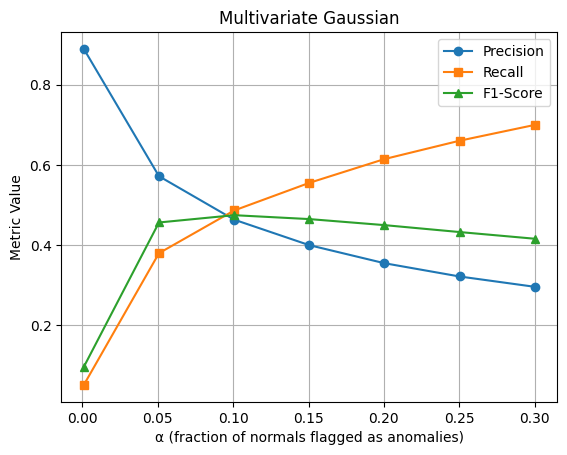

In [27]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Sweep alphas (fraction of normals flagged)
alphas = np.linspace(0.001, 0.3, 7)  # from 1% to 10%
precisions, recalls, f1s = [], [], []

for alpha in alphas:
    # set threshold at the alpha-percentile
    epsilon = np.percentile(train_ll, alpha * 100)
    y_pred = (cv_ll < epsilon).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(
        y_cv, y_pred, pos_label=1, average='binary'
    )
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

# Plot all three metrics against alpha
plt.figure()
plt.plot(alphas, precisions, marker='o', label='Precision')
plt.plot(alphas, recalls,    marker='s', label='Recall')
plt.plot(alphas, f1s,        marker='^', label='F1-Score')
plt.xlabel('α (fraction of normals flagged as anomalies)')
plt.ylabel('Metric Value')
plt.title('Multivariate Gaussian')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from sklearn.mixture import GaussianMixture
#gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)

gmm = GaussianMixture(
    n_components=3,
    covariance_type="full",   # or "tied", "spherical"
    reg_covar=1e-5,           # adds 0.001 to diagonal of each covariance
    #init_params="kmeans",
    random_state=42,
    #max_iter=200
)
gmm.fit(X_train)
train_ll = gmm.score_samples(X_train)
cv_ll    = gmm.score_samples(X_cv)

In [29]:
# pick ε as the α‐percentile of train log‐likelihoods
# e.g. α = 5 means flag ~5% of normals as anomalies in‐sample
α = 30  
epsilon = np.percentile(train_ll, α)

print(f"Chosen ε = {epsilon:.2f} (the {α}th percentile of train log‐likelihood)")

Chosen ε = 172.44 (the 30th percentile of train log‐likelihood)


In [30]:
# anomaly if log‐likelihood < ε
y_pred = (cv_ll < epsilon).astype(int)

In [31]:
cm = confusion_matrix(y_cv, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(
    y_cv, y_pred, pos_label=1, average='binary'
)
#auc = roc_auc_score(y_cv, -cv_ll)  # higher “anomaly score” = more likely fraud

print("Confusion Matrix (CV):")
print(f"             Pred 0    Pred 1")
print(f"Actual 0       {tn:5d}      {fp:5d}")
print(f"Actual 1       {fn:5d}      {tp:5d}\n")

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
#print(f"AUC (using –log‐likelihood): {auc:.3f}")

Confusion Matrix (CV):
             Pred 0    Pred 1
Actual 0       79424      34552
Actual 1        6182      14481

Precision: 0.295
Recall:    0.701
F1-score:  0.416


In [32]:
# compute raw anomaly scores
scores = -cv_ll

# find any +inf (which come from cv_ll == -inf)
inf_mask = np.isinf(scores)
if inf_mask.any():
    # choose a value just above the max finite score
    max_finite = scores[~inf_mask].max()
    scores[inf_mask] = max_finite + 1e-6

# now compute AUC
auc = roc_auc_score(y_cv, scores)
print(f"AUC (using –log‐likelihood, clipped): {auc:.3f}")

AUC (using –log‐likelihood, clipped): 0.773


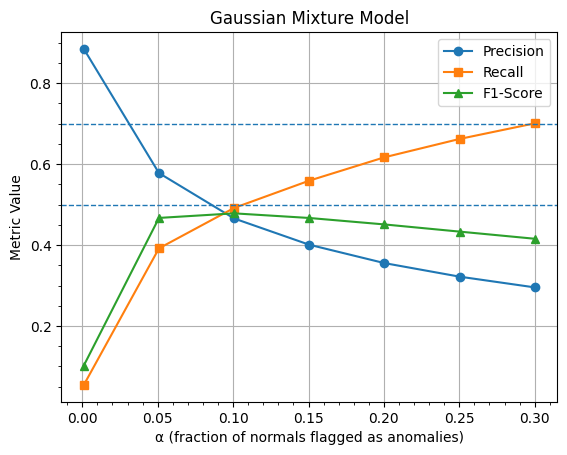

In [33]:
# Sweep alphas (fraction of normals flagged)
alphas = np.linspace(0.001, 0.3, 7)  # from 1% to 10%
precisions, recalls, f1s = [], [], []

for alpha in alphas:
    # set threshold at the alpha-percentile
    epsilon = np.percentile(train_ll, alpha * 100)
    y_pred = (cv_ll < epsilon).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(
        y_cv, y_pred, pos_label=1, average='binary'
    )
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

# Plot all three metrics against alpha
plt.figure()
plt.plot(alphas, precisions, marker='o', label='Precision')
plt.plot(alphas, recalls,    marker='s', label='Recall')
plt.plot(alphas, f1s,        marker='^', label='F1-Score')
# Add horizontal line at y=0.7
plt.axhline(y=0.5, linestyle='--', linewidth=1)
plt.axhline(y=0.7, linestyle='--', linewidth=1)
plt.xlabel('α (fraction of normals flagged as anomalies)')
plt.ylabel('Metric Value')
plt.title('Gaussian Mixture Model')
plt.legend()
plt.minorticks_on()
plt.grid(True)
#plt.grid(which='minor', color='r', linestyle='-', alpha=0.2)
plt.show()